In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import statsmodels.api as sm

# Decide tenor

In [2]:
tenor_to_use = '3m'

# Load dataset

In [3]:
df = pd.read_csv('cip_dataset_v2.csv')
df['date'] = pd.to_datetime(df['date'], format='%d%b%Y')
df.set_index('date', inplace=True)

df.head()

,group,currency,tenor,rho,cip_govt,diff_y
date,,,,,,
1991-04-16,g10,AUD,10y,NaN,NaN,3.06
1991-04-17,g10,AUD,10y,NaN,NaN,2.97
1991-04-18,g10,AUD,10y,NaN,NaN,2.89
1991-04-19,g10,AUD,10y,NaN,NaN,2.81
1991-04-22,g10,AUD,10y,NaN,NaN,2.84


# Plot CIP deviations

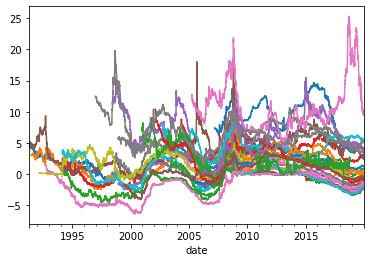

In [4]:
for i, currency in enumerate(df['currency'].unique()):
    df[(df['tenor'] == tenor_to_use) & (df['currency'] == currency)]['diff_y'].plot(label = currency)

In [5]:
group_df = df[df['tenor'] == tenor_to_use].groupby(['group', 'date']).mean()

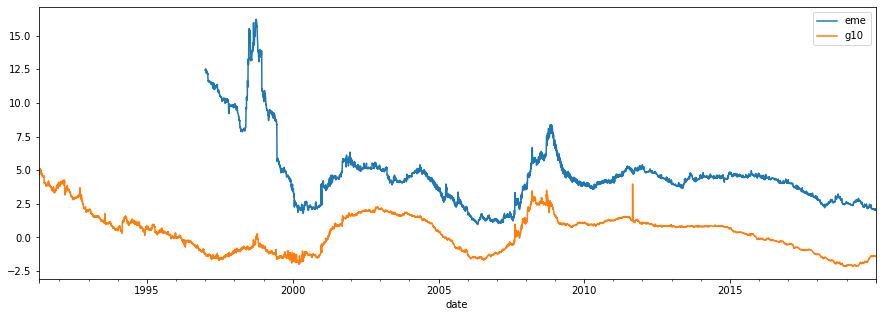

In [6]:
plt.figure(figsize=(15, 5))
group_df.loc['eme']['diff_y'].plot(label='eme')
group_df.loc['g10']['diff_y'].plot(label='g10')
plt.legend();

We cannot say that there is a good correlation in every country.

# CIP vs DXY

In [7]:
import yfinance as yf

In [8]:
dxy_df = yf.download('DX-Y.NYB', progress=False)
dxy_df = dxy_df[['Adj Close']].copy()
dxy_df.rename(columns={'Adj Close': 'DXY'}, inplace=True)

dxy_df

,DXY
Date,
1971-01-04,120.529999
1971-01-05,120.519997
1971-01-06,120.489998
1971-01-07,120.550003
1971-01-08,120.529999
...,...
2020-10-06,93.830002
2020-10-07,93.629997
2020-10-08,93.610001


<AxesSubplot:xlabel='date'>

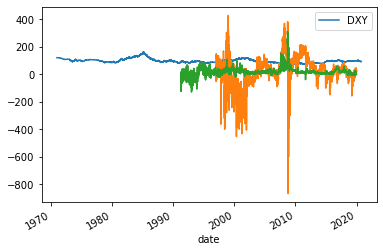

In [9]:
dxy_df.plot()
group_df.loc['eme']['cip_govt'].plot(label='eme')
group_df.loc['g10']['cip_govt'].plot(label='g10')

In [10]:
group_df

rho   cip_govt    diff_y
group date                                      
eme   1996-12-31  12.440416  -0.041639  12.44000
      1997-01-01  12.437226   0.277380  12.44000
      1997-01-02  12.354094   9.590611  12.45000
      1997-01-03  11.870320  59.968005  12.47000
      1997-01-06  12.248804  23.119617  12.48000
...                     ...        ...       ...
g10   2019-12-25  -1.518365  10.783536  -1.41053
      2019-12-26  -1.517050  10.573033  -1.41132
      2019-12-27  -1.419081   3.568111  -1.38340
      2019-12-30  -1.366724  -0.624639  -1.37297
      2019-12-31  -1.364485  -2.652498  -1.39101

[13492 rows x 3 columns]

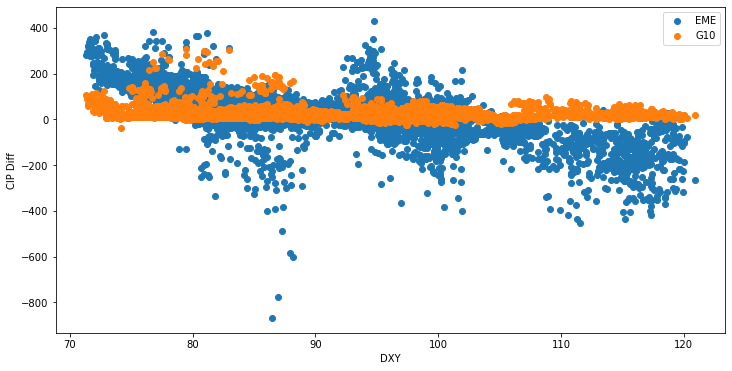

In [11]:
eme_df = group_df.loc['eme']['cip_govt']
g10_df = group_df.loc['g10']['cip_govt']
common_index = dxy_df.index.intersection(eme_df.index)
common_index = common_index.intersection(g10_df.index)

plt.figure(figsize=(12, 6))
plt.scatter(dxy_df.loc[common_index], eme_df.loc[common_index], label='EME')
plt.scatter(dxy_df.loc[common_index], g10_df.loc[common_index], label='G10')

plt.xlabel('DXY')
plt.ylabel('CIP Diff')
plt.legend();

# Country wise

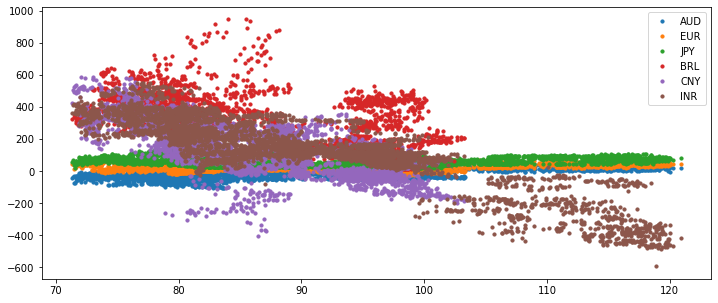

In [41]:
currency_list = ['AUD', 'EUR', 'JPY', 'BRL', 'CNY', 'INR']

plt.figure(figsize=(12, 5))

for ccy in currency_list:
    ccy_df = df[(df['currency'] == ccy) & (df['tenor'] == '5y')]
    common_index = dxy_df.index.intersection(ccy_df.index)

    plt.scatter(dxy_df.loc[common_index], ccy_df.loc[common_index]['cip_govt'], label=ccy, s=10.0)

plt.legend()

# Regression - Countrywise

In [68]:
# not clear
reg_df = pd.DataFrame()

for ccy in currency_list:
    ccy_df = df[(df['currency'] == ccy) & (df['tenor'] == '5y')].dropna()
    common_index = dxy_df.index.intersection(ccy_df.index)

    model = sm.OLS(endog=ccy_df.loc[common_index]['cip_govt'].diff().dropna(),
                   exog=sm.add_constant(dxy_df.loc[common_index].diff().dropna())).fit()
    
    reg_df = reg_df.append({'currency': ccy,
                            'beta' : model.params['DXY'],
                            't-value': model.tvalues['DXY'],
                            'r-squared': round(model.rsquared * 100, 2)},
                           ignore_index=True)

reg_df[['currency', 'beta', 't-value', 'r-squared']]

,currency,beta,t-value,r-squared
0,AUD,-0.404387,-2.181873,0.09
1,EUR,0.093256,0.926188,0.02
2,JPY,0.107662,1.102395,0.02
3,BRL,4.038085,4.341215,0.67
4,CNY,-2.733934,-5.283923,0.70
5,INR,0.278606,0.482268,0.00


# Regression - Group-wise

In [94]:
this_df = eme_df.dropna()
common_index = dxy_df.index.intersection(this_df.index)

em_model = sm.OLS(endog=this_df.loc[common_index].diff().dropna(),
                  exog=sm.add_constant(dxy_df.loc[common_index].diff().dropna())).fit()
em_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               cip_govt   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     36.65
Date:                Mon, 12 Oct 2020   Prob (F-statistic):           1.50e-09
Time:                        19:31:54   Log-Likelihood:                -29184.
No. Observations:                5802   AIC:                         5.837e+04
Df Residuals:                    5800   BIC:                         5.839e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.486      0.027      0.978      -0.939       0.966
DXY           -6.4703      1.069     -6.054      0.000      -8.565      -4.375
==============================================================================
Omnibus:                     2259.577   Durbin-Watson:                   2.609
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1188891.559
Skew:                          -0.399   Prob(JB):                         0.00
Kurtosis:                      73.123   Cond. No.                         2.20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
this_df = g10_df.dropna()
common_index = dxy_df.index.intersection(this_df.index)

g10_model = sm.OLS(endog=this_df.loc[common_index].diff().dropna(),
                   exog=sm.add_constant(dxy_df.loc[common_index].diff().dropna())).fit()
g10_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               cip_govt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.472
Date:                Mon, 12 Oct 2020   Prob (F-statistic):              0.116
Time:                        19:31:55   Log-Likelihood:                -27569.
No. Observations:                7284   AIC:                         5.514e+04
Df Residuals:                    7282   BIC:                         5.516e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.125      0.020      0.984      -0.242       0.247
DXY            0.4257      0.271      1.572      0.116      -0.105       0.957
==============================================================================
Omnibus:                     1874.599   Durbin-Watson:                   2.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           154077.697
Skew:                           0.045   Prob(JB):                         0.00
Kurtosis:                      25.531   Cond. No.                         2.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
pd.DataFrame(
    data = [[em_model.params['DXY'], g10_model.params['DXY']],
            [em_model.tvalues['DXY'], g10_model.tvalues['DXY']],
            [em_model.rsquared, g10_model.rsquared]],
    index = ['beta', 't-value', 'r-squared'],
    columns = ['EM', 'G10']).round(4)

,EM,G10
beta,-6.4703,0.4257
t-value,-6.0543,1.5722
r-squared,0.0063,0.0003
